The 4-split seems to train way worse than with the old structure. It seems less Dense layers close to the bottleneck cope better with translated images..

In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
#         self.regressor = self._create_regressor(latent_dim)
#         self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
#         y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='same', name='pt_conv'),  # Introduce point convolution at end
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense((io_shape[0]-4)*(io_shape[1]-4)),
            Reshape((io_shape[0]-4,io_shape[1]-4,1)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=1, kernel_size=(1,1), padding='valid'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='linear')
        ])

In [2]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')

Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0336 - val_loss: 0.0202
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0196 - val_loss: 0.0187
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0181 - val_loss: 0.0171
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0172 - val_loss: 0.0163
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 6/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0161 - val_loss: 0.0155
Epoch 7/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 8/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 9/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 10/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0

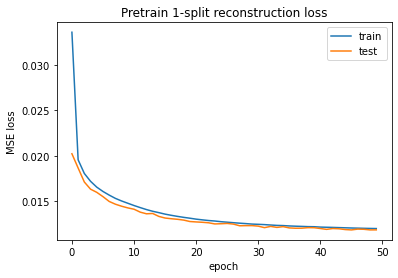

<Figure size 432x288 with 0 Axes>

In [3]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=50, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pretrain 1-split reconstruction loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('../img/31/CE4_newDecoderStruct_epoch50.png')

In [4]:
model.encoder.save_weights('../weights/31_CE4x4_epoch50.h5')

For comparison, add more units in the decoder, close to bottleneck. This definitly seems to help, although for 16-split it breaks training.

In [14]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
#         self.regressor = self._create_regressor(latent_dim)
#         self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
#         y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='linear', padding='same', name='pt_conv'),  # Introduce point convolution at end
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense((io_shape[0]-4)*(io_shape[1]-4)*32),
            Reshape((io_shape[0]-4,io_shape[1]-4,32)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=1, kernel_size=(1,1), padding='valid'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='linear')
        ])

In [15]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')

In [16]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0230 - val_loss: 0.0157
Epoch 2/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0149 - val_loss: 0.0138
Epoch 3/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 4/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 5/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 8/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 9/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 10/25
1875/1875 [==============================] - 11s 6ms/step - l

How about getting rid of the point convolution at the end of the encoder? That improves things even more.. So the mechanisms responsible for performance improvement for 4-split are the reason the training comes to a halt for 16-split.

In [11]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
#         self.regressor = self._create_regressor(latent_dim)
#         self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
#         y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense((io_shape[0]-4)*(io_shape[1]-4)*32),
            Reshape((io_shape[0]-4,io_shape[1]-4,32)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=1, kernel_size=(1,1), padding='valid'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='linear')
        ])

In [12]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')

In [13]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0202 - val_loss: 0.0128
Epoch 2/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 3/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 4/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 5/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 8/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 9/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/25
1875/1875 [==============================] - 11s 6ms/step - l

Check wo/ point conv, but with reduced decoder Reshape layer. We see only the combination of many channels before and after the latent space gives good reco loss.

In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
#         self.regressor = self._create_regressor(latent_dim)
#         self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
#         y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense((io_shape[0]-4)*(io_shape[1]-4)),
            Reshape((io_shape[0]-4,io_shape[1]-4,1)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
            Conv2DTranspose(filters=1, kernel_size=(1,1), padding='valid'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(2, activation='linear')
        ])

In [2]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')

In [3]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0251 - val_loss: 0.0164
Epoch 2/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 4/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0131 - val_loss: 0.0128
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 8/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 9/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 10/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0